In [1]:
import os
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image, ImageDraw
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.optim as optim

In [2]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [3]:
img_datapath = "/srv/data/lt2326-h25/a1/images"
info_datapath = "/srv/data/lt2326-h25/a1/info.json"
ann_datapath = "/srv/data/lt2326-h25/a1/train.jsonl"

Dataset definition

In [4]:
class BinaryImageSegmentation(Dataset):
    def __init__(self, img_dir, ann_file, info_file, img_size=256):
        self.img_size = img_size

        self.names = []
        with open(info_file, "r", encoding="utf-8") as a:
            info = json.load(a)
            for item in info["train"]:
                self.names.append(item["file_name"])

        self.img_files = {}
        for f in os.listdir(img_dir):
            name = os.path.basename(f)
            if name in self.names:
                self.img_files[name] = os.path.join(img_dir, f)
                
        self.samples = []
        with open(ann_file, "r", encoding="utf-8") as f:
            for line in f:
                obj = json.loads(line)
                if obj["file_name"] in self.img_files:
                    self.samples.append(obj)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        file_name = sample["file_name"]
        img_path = self.img_files[file_name]

        #load image
        image = Image.open(img_path).convert("RGB")
        w, h = image.size
        image = image.resize((self.img_size, self.img_size), Image.BILINEAR)

        image = transforms.functional.to_tensor(image)
        image = transforms.functional.normalize(image, mean=[0.5]*3, std=[0.5]*3)

        #create blank binary mask
        bi_mask = Image.new("L", (w, h), 0)
        draw = ImageDraw.Draw(bi_mask)

        # draw polygons from ann
        for ann_group in sample.get("annotations", []):
            for ann in ann_group:
                if isinstance(ann, dict):
                    if ann.get("is_chinese") and not ann.get("ignore"):
                        polygon = [tuple(p) for p in ann["polygon"]]
                        draw.polygon(polygon, outline=1, fill=1)

        bi_mask = bi_mask.resize((self.img_size, self.img_size), Image.NEAREST)
        bi_mask = torch.from_numpy(np.array(bi_mask)).long()
        bi_mask = bi_mask.unsqueeze(0)
        return image, bi_mask
        
                           

Dataset split function

In [5]:
def split_dataset(dataset, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, seed=26):
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6

    tot_len = len(dataset)
    train_len = int(tot_len*train_ratio)
    val_len = int(tot_len*val_ratio)
    test_len = tot_len - train_len - val_len

    generator = torch.Generator().manual_seed(seed)
    return random_split(dataset, [train_len, val_len, test_len], generator=generator)
    

Create Dataset and split

In [6]:
dataset = BinaryImageSegmentation(
    img_dir=img_datapath,
    ann_file=ann_datapath,
    info_file=info_datapath,
    img_size=256
)

train_dataset, val_dataset, test_dataset = split_dataset(dataset)

Create dataloaders

In [7]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

create training loop

In [8]:
def epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for imgs, masks in dataloader:
        imgs, masks = imgs.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, masks.float())
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss /len(dataloader)

In [9]:
def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    preds, gts = [], []
    with torch.no_grad():
        for imgs, masks in dataloader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, masks.float())
            total_loss += loss.item()

            preds.append(torch.sigmoid(outputs).cpu().numpy())
            gts.append(masks.cpu().numpy())

    preds = np.concatenate(preds, axis=0)
    gts = np.concatenate(gts, axis=0)
    return total_loss/len(dataloader), preds, gts

In [10]:
def dice_loss(preds, masks, smooth=1e-6):
    preds = preds.contiguous().view(-1)
    masks = masks.contiguous().view(-1)

    intersection = (preds * masks).sum()
    dice = (2. * intersection + smooth) / (preds.sum() + masks.sum() + smooth)
    return 1 - dice

In [11]:
class BCE_DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6, bce_weight=0.5, dice_weight=0.5):
        super().__init__()
        self.smooth = smooth
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
        self.bce = nn.BCELoss()

    def forward(self, preds, masks):
        bce_loss = self.bce(preds, masks)
        d_loss = dice_loss(preds, masks, smooth=self.smooth)
        loss = self.bce_weight * bce_loss + self.dice_weight * d_loss
        return loss

In [12]:
def train_model(model, train_loader, val_loader, test_loader, device, epochs=50):
    from lab1_eval import (plot_training_curve, eval_threshold, iou, dice, eval_testset, visualize_pred)
    
    criterion = BCE_DiceLoss()
    optimizer = optim.Adam(model.parameters())

    train_losses, val_losses = [], []
    best_val_loss = float("inf")

    for e in range(epochs):
        train_loss = epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_preds, val_masks = validate(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch {e+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

        if val_loss > best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model.pth")

    #eval after training
    

    
    plot_training_curve(train_losses, val_losses)

    thresholds = np.linspace(0.1, 0.9, 9)
    metrics = eval_threshold(val_masks, val_preds, thresholds)
    for m in metrics:
        print(f"Threshold={m['threshold']:.2f} | Precision={m['precision']:.3f} | Recall={m['recall']:.3f} | F1={m['f1']:.3f} | Accuracy={m['accuracy']:.3f}")

    best_threshold = max(metrics, key=lambda x: x['f1'])['threshold']
    print(f'Best threshold for validations set: {best_threshold}')
    
    _, test_preds, test_masks = validate(model, test_loader, criterion, device)
    test_metrics = eval_testset(test_preds, test_masks, threshold=best_threshold)
    print(f"Final test metrics: {test_metrics}")

    for i in range(3):
        img, mask = test_loader.dataset[i]
        visualize_pred(img.permute(1, 2, 0), mask, test_preds[i])
    

Initialise model

Epoch 1/25 | Train Loss: 0.6216 | Val Loss: 0.5575
Epoch 2/25 | Train Loss: 0.5297 | Val Loss: 0.5121
Epoch 3/25 | Train Loss: 0.4937 | Val Loss: 0.4890
Epoch 4/25 | Train Loss: 0.4645 | Val Loss: 0.4612
Epoch 5/25 | Train Loss: 0.4501 | Val Loss: 0.4539
Epoch 6/25 | Train Loss: 0.4380 | Val Loss: 0.4410
Epoch 7/25 | Train Loss: 0.4321 | Val Loss: 0.4422
Epoch 8/25 | Train Loss: 0.4215 | Val Loss: 0.4302
Epoch 9/25 | Train Loss: 0.4110 | Val Loss: 0.4135
Epoch 10/25 | Train Loss: 0.3949 | Val Loss: 0.4249
Epoch 11/25 | Train Loss: 0.3906 | Val Loss: 0.3928
Epoch 12/25 | Train Loss: 0.3768 | Val Loss: 0.3985
Epoch 13/25 | Train Loss: 0.3744 | Val Loss: 0.3917
Epoch 14/25 | Train Loss: 0.3632 | Val Loss: 0.3734
Epoch 15/25 | Train Loss: 0.3522 | Val Loss: 0.3646
Epoch 16/25 | Train Loss: 0.3461 | Val Loss: 0.3564
Epoch 17/25 | Train Loss: 0.3353 | Val Loss: 0.3680
Epoch 18/25 | Train Loss: 0.3331 | Val Loss: 0.3471
Epoch 19/25 | Train Loss: 0.3258 | Val Loss: 0.3555
Epoch 20/25 | Train L

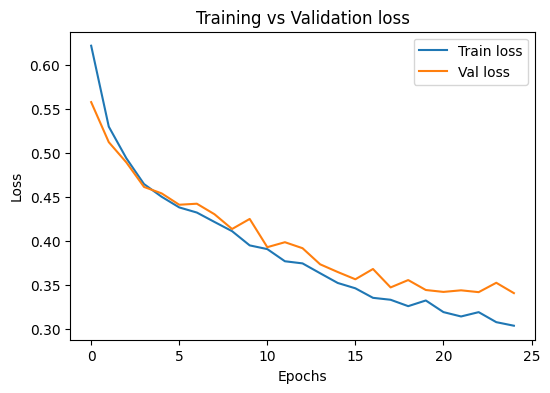

/usr/local/lib64/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib64/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Threshold=0.10 | Precision=0.004 | Recall=1.000 | F1=0.009 | Accuracy=0.004
Threshold=0.20 | Precision=0.004 | Recall=1.000 | F1=0.009 | Accuracy=0.004
Threshold=0.30 | Precision=0.004 | Recall=1.000 | F1=0.009 | Accuracy=0.004
Threshold=0.40 | Precision=0.004 | Recall=1.000 | F1=0.009 | Accuracy=0.004
Threshold=0.50 | Precision=0.004 | Recall=0.999 | F1=0.009 | Accuracy=0.010
Threshold=0.60 | Precision=0.368 | Recall=0.383 | F1=0.375 | Accuracy=0.994
Threshold=0.70 | Precision=0.436 | Recall=0.334 | F1=0.378 | Accuracy=0.995
Threshold=0.80 | Precision=0.000 | Recall=0.000 | F1=0.000 | Accuracy=0.996
Threshold=0.90 | Precision=0.000 | Recall=0.000 | F1=0.000 | Accuracy=0.996
Best threshold for validations set: 0.7000000000000001


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..1.0].


Final test metrics: {'mean IoU': 0.1939890821926948, 'mean Dice': 2.397931183814101e-06, 'mean MSE': 0.2506096468875457}


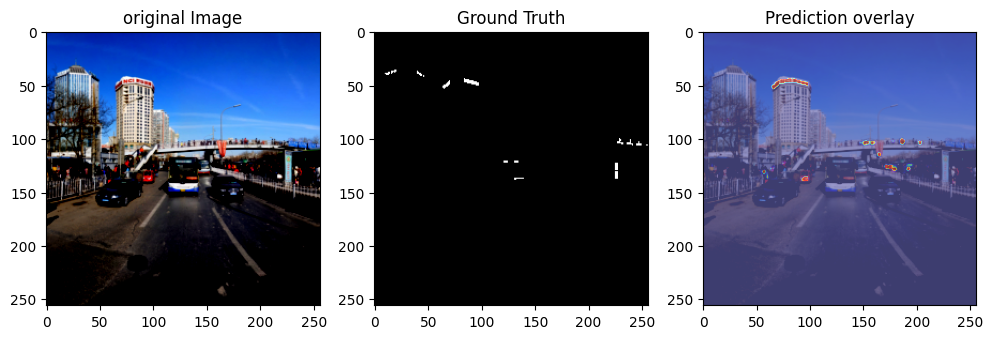

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.96862745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.96862745].


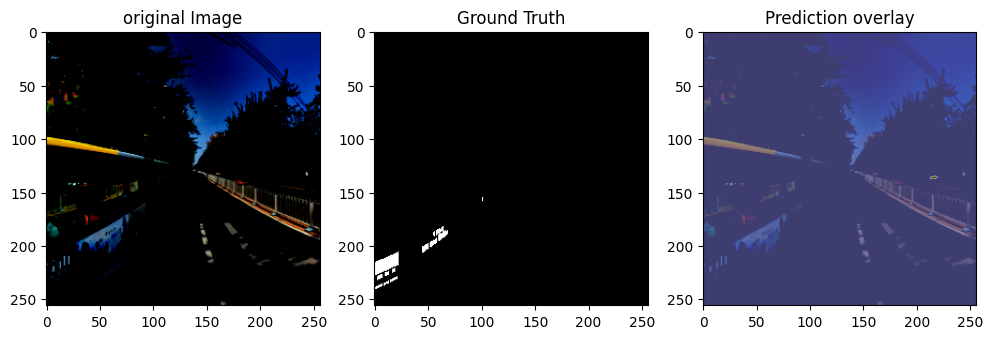

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


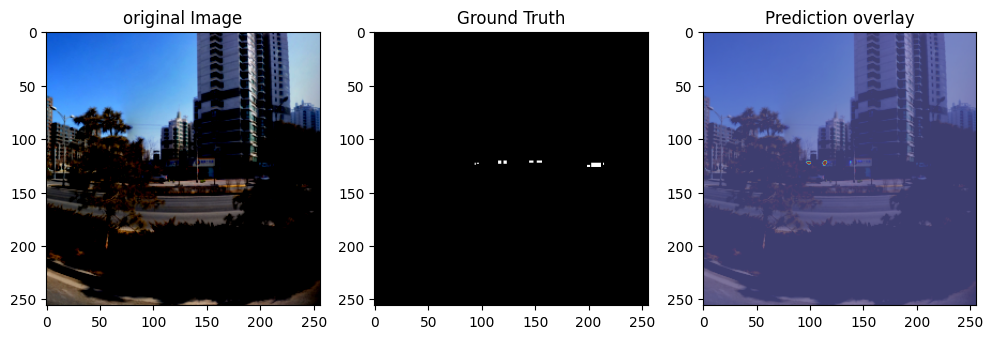

In [13]:
from UNet import PixelPredictModel_UNet 
UNet_model = PixelPredictModel_UNet(in_ch=3, out_ch=1).to(device)

train_model(UNet_model, train_loader=train_loader,val_loader=val_loader, test_loader=test_loader, device=device, epochs=25)

Epoch 1/25 | Train Loss: 0.6661 | Val Loss: 0.5548
Epoch 2/25 | Train Loss: 0.5337 | Val Loss: 0.5206
Epoch 3/25 | Train Loss: 0.5169 | Val Loss: 0.5368
Epoch 4/25 | Train Loss: 0.5001 | Val Loss: 0.4892
Epoch 5/25 | Train Loss: 0.4661 | Val Loss: 0.4823
Epoch 6/25 | Train Loss: 0.4491 | Val Loss: 0.4587
Epoch 7/25 | Train Loss: 0.4347 | Val Loss: 0.4312
Epoch 8/25 | Train Loss: 0.4288 | Val Loss: 0.4361
Epoch 9/25 | Train Loss: 0.4244 | Val Loss: 0.4216
Epoch 10/25 | Train Loss: 0.4074 | Val Loss: 0.4331
Epoch 11/25 | Train Loss: 0.4063 | Val Loss: 0.4114
Epoch 12/25 | Train Loss: 0.3903 | Val Loss: 0.4363
Epoch 13/25 | Train Loss: 0.3916 | Val Loss: 0.4098
Epoch 14/25 | Train Loss: 0.3795 | Val Loss: 0.3913
Epoch 15/25 | Train Loss: 0.3786 | Val Loss: 0.3927
Epoch 16/25 | Train Loss: 0.3733 | Val Loss: 0.3831
Epoch 17/25 | Train Loss: 0.3617 | Val Loss: 0.3869
Epoch 18/25 | Train Loss: 0.3589 | Val Loss: 0.4050
Epoch 19/25 | Train Loss: 0.3592 | Val Loss: 0.3862
Epoch 20/25 | Train L

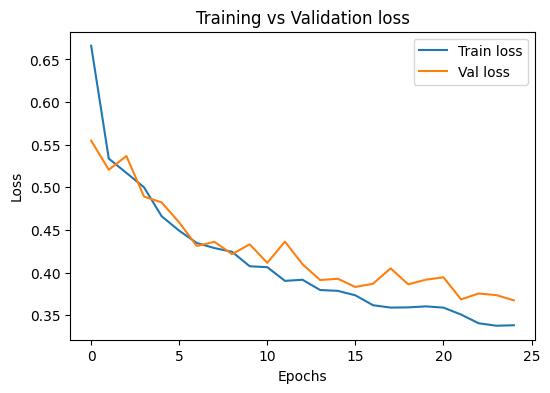

/usr/local/lib64/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib64/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Threshold=0.10 | Precision=0.004 | Recall=1.000 | F1=0.009 | Accuracy=0.004
Threshold=0.20 | Precision=0.004 | Recall=1.000 | F1=0.009 | Accuracy=0.004
Threshold=0.30 | Precision=0.004 | Recall=1.000 | F1=0.009 | Accuracy=0.004
Threshold=0.40 | Precision=0.004 | Recall=1.000 | F1=0.009 | Accuracy=0.004
Threshold=0.50 | Precision=0.004 | Recall=0.997 | F1=0.009 | Accuracy=0.006
Threshold=0.60 | Precision=0.338 | Recall=0.306 | F1=0.321 | Accuracy=0.994
Threshold=0.70 | Precision=0.388 | Recall=0.269 | F1=0.317 | Accuracy=0.995
Threshold=0.80 | Precision=0.000 | Recall=0.000 | F1=0.000 | Accuracy=0.996
Threshold=0.90 | Precision=0.000 | Recall=0.000 | F1=0.000 | Accuracy=0.996
Best threshold for validations set: 0.6
Final test metrics: {'mean IoU': 0.1409305150784062, 'mean Dice': 2.1038669042644844e-06, 'mean MSE': 0.250737906222924}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..1.0].


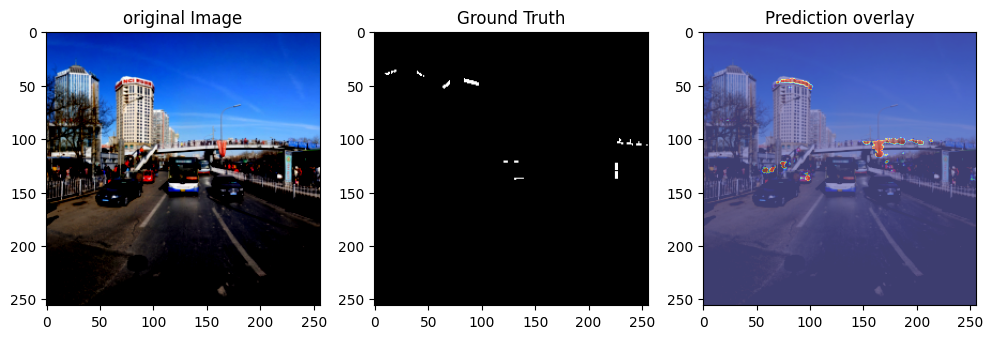

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.96862745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.96862745].


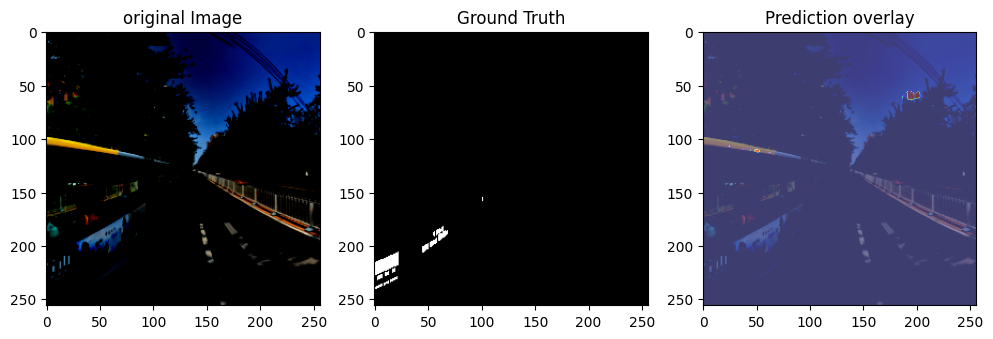

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


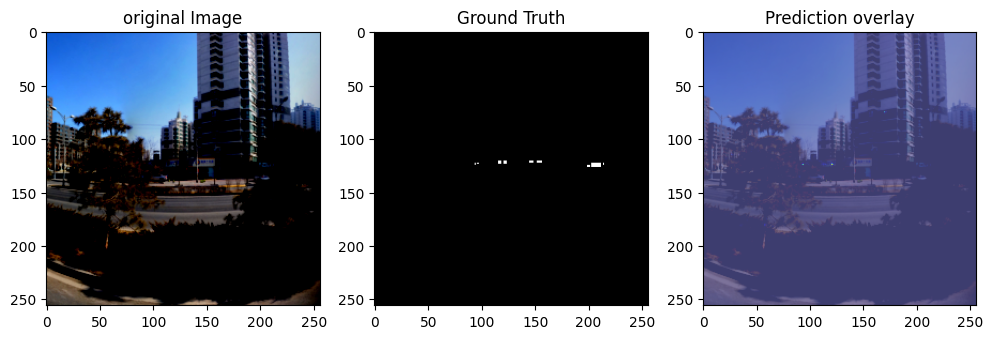

In [14]:
from SegNet import PixelPredictModel_SegNet
SegNet_model = PixelPredictModel_SegNet(in_ch=3, out_ch=1).to(device)

train_model(SegNet_model, train_loader=train_loader,val_loader=val_loader, test_loader=test_loader, device=device, epochs=25)